In [99]:
# In this notebook, we try to add nonlinear operation locally
# in PyTorch for "Retina Blood Vessel" dataset
#

In [192]:
# imports
#
import sys
import os
import glob
import time
import numpy as np
import scipy as sp
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm
import matplotlib.pyplot as plt
import plotly
import plotly.subplots
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

import torch, torchvision

from IPython.core.debugger import set_trace

In [101]:
# Globals
#
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6
br = set_trace

In [283]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath)
train_masks = 1 * (read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath)
test_masks = 1 *(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)
print(train_images.min(), train_images.max(), train_images.mean())
print(train_masks.min(), train_masks.max(), train_masks.mean())

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)
-1.5989004704853944 4.097728417232479 1.5034270125132329e-18
0 1 0.12315158843994141


In [569]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.float64(img)
            # img = (img - img.min()) / (img.max() + EPSILON)
            # img = 2*img - 1
            # img = np.float64(img)/img.max()
            img = (img - img.mean()) / img.std()
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

class Nonlinear(torch.nn.Module):
    def __init__(self, ksize: tuple=(3, 1, 1), ich=3):
        super().__init__()
        self.ksize = ksize
        nfeats = ich*np.product(ksize[1:])
        # self.kernel = torch.nn.Parameter(torch.randn(ksize))
        self.func = torch.nn.Sequential(torch.nn.Linear(nfeats, 2),)
        # self.params = torch.nn.Parameter(torch.randn(ksize))
        # self.func = 
        
        # self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x, y=None):
        """
        x: images batch
        y: targets batch
        """
        xuf = self.img_unfold(x)
        xuf = xuf.flatten(2, -1)
        nlin = self.func(xuf)
        # for target
        yuf = None
        if y != None:
            yuf = y.flatten(1, -1)
        return nlin, yuf

    def img_unfold(self, x):
        kc, kh, kw = self.ksize  # kernel size
        dc, dh, dw = 1, 1, 1  # stride
        # Pad
        xp = torch.nn.functional.pad(x,
                                     (x.size(3)%kw // 2, x.size(3)%kw // 2,
                                      x.size(2)%kh // 2, x.size(2)%kh // 2,
                                      x.size(1)%kc // 2, x.size(1)%kc // 2))
        patches = xp.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
        patches = patches.contiguous().view(x.shape[0], -1, kc, kh, kw)
        return patches


# Locally Nonlinear Block
class LocallyNonlinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=3,
                            kernel_size=1, stride=1, 
                            padding='same', bias=True))
        br()
                # torch.nn.LogSigmoid()))
                # torch.nn.Identity()))
                # torch.nn.ReLU()))
                # torch.nn.Tanh()))
                # Activ()))
        # self.conv3 = torch.nn.Sequential(
        #     torch.nn.Conv2d(in_channels=3, out_channels=1,
        #                     kernel_size=3, stride=1, 
        #                     padding='same', bias=True))
        self.aggregate = torch.nn.Conv2d(in_channels=3, out_channels=1,
                                         kernel_size=1, stride=1,
                                         padding='same', bias=True)
        self.sigmoid = torch.nn.Sigmoid()
        
        # weight = torch.ones_like(self.conv.weight)
        # weight /= weight.sum()
        # self.conv.weight = torch.nn.parameter.Parameter(weight,
        #                                                 requires_grad=False)
        
    def forward(self, batch):
        # print(batch.shape)
        out = self.conv1(batch)
        out = torch.concatenate(out, axis=1)
        out = self.aggregate(out)
        out = self.sigmoid(out)
        # print(out.shape)
        return out


class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
class Train:
    """
    Initialize, train, evaluate, decode
    """
    def __init__(self, model, data, label, nepoch=4, bsize=8):
        """
        data: [batch, num_channel, rows, cols]
        label: [batch, num_channel, rows, cols]
        """
        self.model = model
        self.data = data
        self.label = label
        self.nepoch = nepoch
        self.device = (torch.device("mps")
                       if torch.backends.mps.is_available()
                       else torch.device('cpu'))
        weight = torch.Tensor([label.sum()/label.numel(),
                               1-label.sum()/label.numel()])
        print('Weight: ', weight)
        self.crit = torch.nn.CrossEntropyLoss(weight=weight.to(self.device))
        # self.crit = torch.nn.MSELoss()
        # self.crit = DiceLoss()
        # self.crit = DiceBCELoss()
        self.bsize = bsize
    def run(self, lr=1e-4):
        model = self.model
        model = model.to(self.device)
        crit = self.crit
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        # sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optim, factor=0.5, patience=4, threshold=0.001)
        t1 = time.time()
        for epoch in range(self.nepoch):
            # t1 = time.time()
            model, optim = self._train(model, crit, optim)
            # model.train()
            # for bc in range(1, self.data.shape[0] // self.bsize):
            #     slc = slice((bc-1)*self.bsize, bc*self.bsize)
            #     batch, lb = self.data[slc], self.label[slc]
            #     batch, lb = batch.to(self.device), lb.to(self.device)
            #     optim.zero_grad()
            #     out = model(batch).squeeze(dim=1)
            #     loss = crit(out, lb)
            #     loss.backward()
            #     optim.step()
            
            loss = self._valid(model, crit)
            # sch.step(loss)
            # if lr != optim.param_groups[0]['lr']:
            #     lr = optim.param_groups[0]['lr']
            #     print(f'Learning rate changed to {lr:.04f}.')
            if (epoch % 10 == 0) | (epoch == (self.nepoch-1)):
                print(f'Ep: {epoch}, Secs: {time.time() - t1:.0f}, ' +
                      f'loss: {loss:.04f}')
                t1 = time.time()
        return model
            
    def _train(self, model, crit, optim):
        model.train()
        for bc in range(1, self.data.shape[0] // self.bsize + 1):
            slc = slice((bc-1)*self.bsize, bc*self.bsize)
            batch, lb = self.data[slc, :, :, :], self.label[slc]
            batch, lb = batch.to(self.device), lb.to(self.device)
            optim.zero_grad()
            out, lbunf = model(batch, lb)
            out = out.softmax(dim=2)
            # for CrossEntropy Loss
            dec, targ = out.flatten(0, 1), lbunf.flatten()
            loss = crit(dec, targ)
            loss.backward()
            optim.step()
        return model, optim
    
    def _valid(self, model, crit):
        model = model.to(self.device)
        model.eval()
        loss_sum = 0.0
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device)
                out, lbunf = model(batch, lb)
                out = out.softmax(dim=2)
                # for CrossEntropy Loss
                dec, targ = out.flatten(0, 1), lbunf.flatten()
                loss = crit(dec, targ)
                loss_sum += loss.item()
        return loss_sum / bc

    def decode(self, model):
        model = model.to(self.device)
        model.eval()
        decs = []
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device)
                out = model(batch)[0].reshape(lb.shape + (2, ))[:, :, :, 1]
                decs += out.detach().cpu().tolist()
        decs = np.array(decs)
        return decs



In [566]:
nl = Nonlinear(ksize=(3, 1, 1), ich = 3)
# shift channel to the second position
train_images_tensors = torch.Tensor(train_images).swapdims(2, 3).swapdims(1, 2)
train = Train(nl, train_images_tensors,
              torch.Tensor(train_masks), nepoch=30, bsize=20)
t0 = time.time()
model = train.run(lr=1.0e-2)
decs = train.decode(model)
print(f'Finished in {time.time() - t0:.0f} seconds.')
# Records:
#    Time: 299, Loss: 1.1772 

Weight:  tensor([0.1232, 0.8768])
Ep: 0, Secs: 102, loss: 0.7049
Ep: 10, Secs: 1021, loss: 0.6342
Ep: 20, Secs: 1022, loss: 0.6288
Ep: 29, Secs: 920, loss: 0.6273
Finished in 3117 seconds.


True

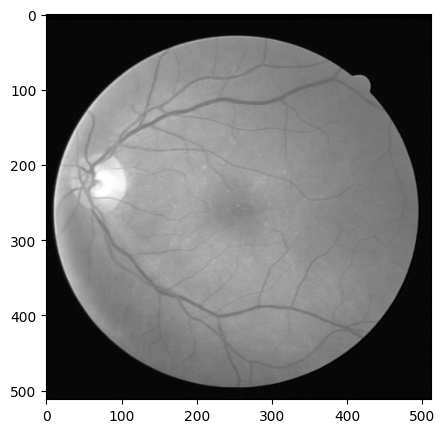

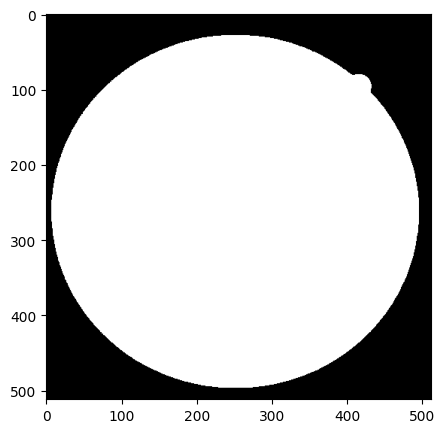

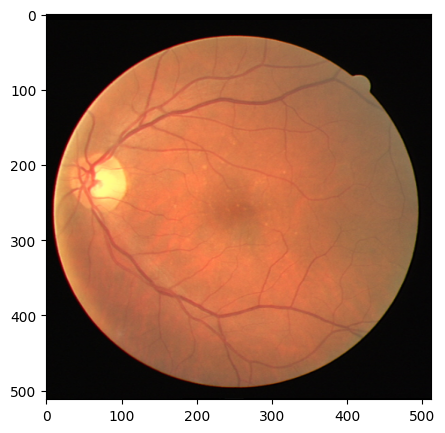

In [568]:
n = 0
show(decs[n, :, :])
show(decs[n, :, :] > 0.0)
show(train_images[n, :, :, :])

In [567]:
# decs = train.decode(model)

In [391]:
decs.min(), decs.max()

(-0.9436759948730469, 0.9901959300041199)

In [516]:
x[2, :, :3, :3]

tensor([[[216., 217., 218.],
         [222., 223., 224.],
         [228., 229., 230.]],

        [[252., 253., 254.],
         [258., 259., 260.],
         [264., 265., 266.]],

        [[288., 289., 290.],
         [294., 295., 296.],
         [300., 301., 302.]]])

In [478]:
a[0*5*5 + 5//2*5 + 5//2], a[1*5*5 + 5//2*5 + 5//2], a[2*5*5 + 5//2*5 + 5//2]

(tensor(14.), tensor(50.), tensor(86.))

In [539]:
x = torch.arange(4 * 3 * 512 * 512).reshape(4, 3, 512, 512).float()
kc, kh, kw = 3, 1, 1  # kernel size
dc, dh, dw = 1, 1, 1  # stride
# Pad to multiples
x = torch.nn.functional.pad(x, (x.size(3)%kw // 2, x.size(3)%kw // 2,
                                x.size(2)%kh // 2, x.size(2)%kh // 2,
                                x.size(1)%kc // 2, x.size(1)%kc // 2))
print(x.shape)
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
# patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
print(unfold_shape)
patches = patches.contiguous().view(x.shape[0], -1, kc, kh, kw)
print(patches.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512, 3, 1, 1])
torch.Size([4, 262144, 3, 1, 1])


In [541]:
x.unfold(2, kh, dh).shape

torch.Size([4, 3, 512, 512, 1])

In [517]:
patches[2, 0, :, :]

tensor([[[216., 217., 218.],
         [222., 223., 224.],
         [228., 229., 230.]],

        [[252., 253., 254.],
         [258., 259., 260.],
         [264., 265., 266.]],

        [[288., 289., 290.],
         [294., 295., 296.],
         [300., 301., 302.]]])